# Exploratory Data Analysis on Category Tree Dataset

In this notebook, we will perform exploratory data analysis (EDA) on the `category_tree.csv` dataset to understand its structure and contents.

## Loading the Dataset

We will load the dataset and display its basic information to understand its structure.

In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
sns.set(style="whitegrid")
%matplotlib inline

# Define chunk size for large datasets
CHUNK_SIZE = 100000  # Process 100,000 rows at a time

# Display basic info about category_tree.csv (small enough to load fully)
category_tree = pd.read_csv("../data/category_tree.csv")
print("Category Tree Dataset Info:")
print(category_tree.info())

## Displaying the First Few Rows

## Now, let's take a look at the first few rows of the dataset to get a sense of what data we are working with.
print("\nFirst few rows:")
print(category_tree.head())

Category Tree Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB
None

First few rows:
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0


## Basic Observations

- The `category_tree.csv` dataset has 1,669 rows with columns: `categoryid`, `parentid`.
- The `events.csv` and `item_properties.csv` datasets are large, so we'll process them in chunks to analyze user interactions and item properties.

Event Type Distribution:
view           2664312
addtocart        69332
transaction      22457
dtype: int64


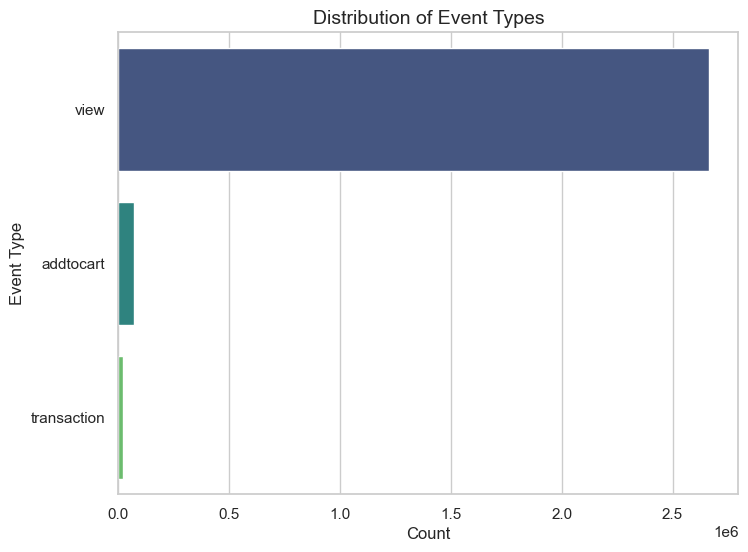


Event Type Proportions:
view           0.966696
addtocart      0.025156
transaction    0.008148
dtype: float64


In [12]:
import os  # Import os to handle directory operations

# Initialize counters for event types
event_counts = pd.Series(0, index=['view', 'addtocart', 'transaction'])

# Process events.csv in chunks
for chunk in pd.read_csv("../data/events.csv", chunksize=CHUNK_SIZE):
    # Count event types in this chunk
    chunk_counts = chunk['event'].value_counts()
    # Add to total counts
    event_counts = event_counts.add(chunk_counts, fill_value=0)

print("Event Type Distribution:")
print(event_counts)

# Plot event type distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=event_counts.values, y=event_counts.index, palette="viridis", hue=event_counts.index)  # Added hue parameter
plt.title("Distribution of Event Types", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Event Type", fontsize=12)

# Create the visualizations directory if it doesn't exist
visualization_dir = "../visualizations/"
os.makedirs(visualization_dir, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(visualization_dir, "event_distribution.png"))
plt.show()

# Calculate proportions
event_proportions = event_counts / event_counts.sum()
print("\nEvent Type Proportions:")
print(event_proportions)

## Event Type Insights

The distribution of event types in `events.csv` reveals a significant imbalance in user interactions, which poses a challenge for the recommendation system. Below is a detailed breakdown:

### Event Type Distribution
| Event Type     | Count      | Proportion |
|----------------|------------|------------|
| View           | 2,664,312  | 96.67%     |
| Add-to-Cart    | 69,332     | 2.52%      |
| Transaction    | 22,457     | 0.82%      |


### Key Observations
- **Views Dominate**: View events account for 96.7% of all interactions (2,664,312 events), indicating that most users browse items without taking further actions.
- **Low Conversion Rates**: Add-to-cart events make up 2.5% (69,332 events), and transactions are only 0.8% (22,457 events). This imbalance highlights the difficulty of predicting and encouraging conversions, a key challenge for the recommendation system.
- **Implications**: The system must focus on strategies to convert views into add-to-carts and transactions, possibly by prioritizing popular items or leveraging temporal patterns.

View to Add-to-Cart Rate: 2.60%
Add-to-Cart to Transaction Rate: 32.39%
View to Transaction Rate: 0.84%


C:\Users\hbempong\AppData\Local\Temp\ipykernel_3044\2479604151.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Stage', data=funnel_data, palette="Blues_d")


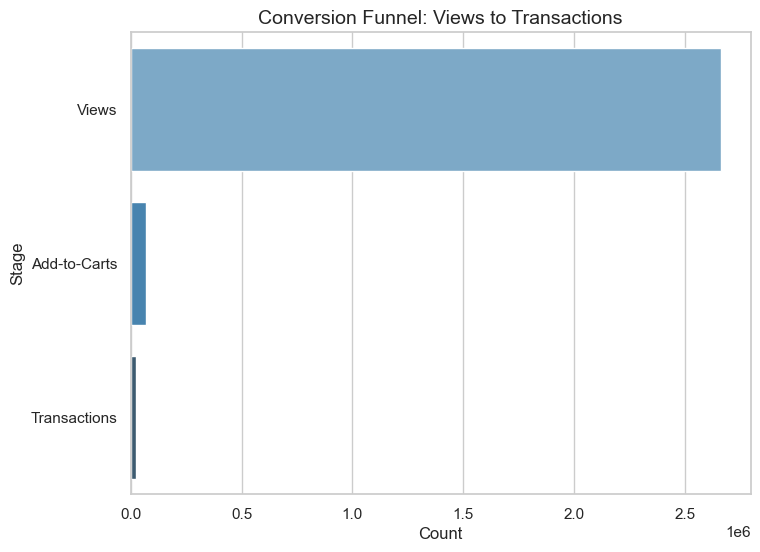

In [13]:
# Use event counts from previous step for conversion funnel
total_views = event_counts['view']
total_addtocarts = event_counts['addtocart']
total_transactions = event_counts['transaction']

view_to_addtocart_rate = total_addtocarts / total_views * 100
addtocart_to_transaction_rate = total_transactions / total_addtocarts * 100
view_to_transaction_rate = total_transactions / total_views * 100

print(f"View to Add-to-Cart Rate: {view_to_addtocart_rate:.2f}%")
print(f"Add-to-Cart to Transaction Rate: {addtocart_to_transaction_rate:.2f}%")
print(f"View to Transaction Rate: {view_to_transaction_rate:.2f}%")

# Plot conversion funnel
funnel_data = pd.DataFrame({
    'Stage': ['Views', 'Add-to-Carts', 'Transactions'],
    'Count': [total_views, total_addtocarts, total_transactions]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Stage', data=funnel_data, palette="Blues_d")
plt.title("Conversion Funnel: Views to Transactions", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Stage", fontsize=12)
plt.savefig("../visualizations/conversion_funnel.png")
plt.show()

## Conversion Funnel Insights

- Only 2.52% of views lead to add-to-carts, and 32.39% of add-to-carts result in transactions.
- The overall view-to-transaction rate is very low (0.82%), indicating a key challenge for the recommendation system: encouraging conversions.

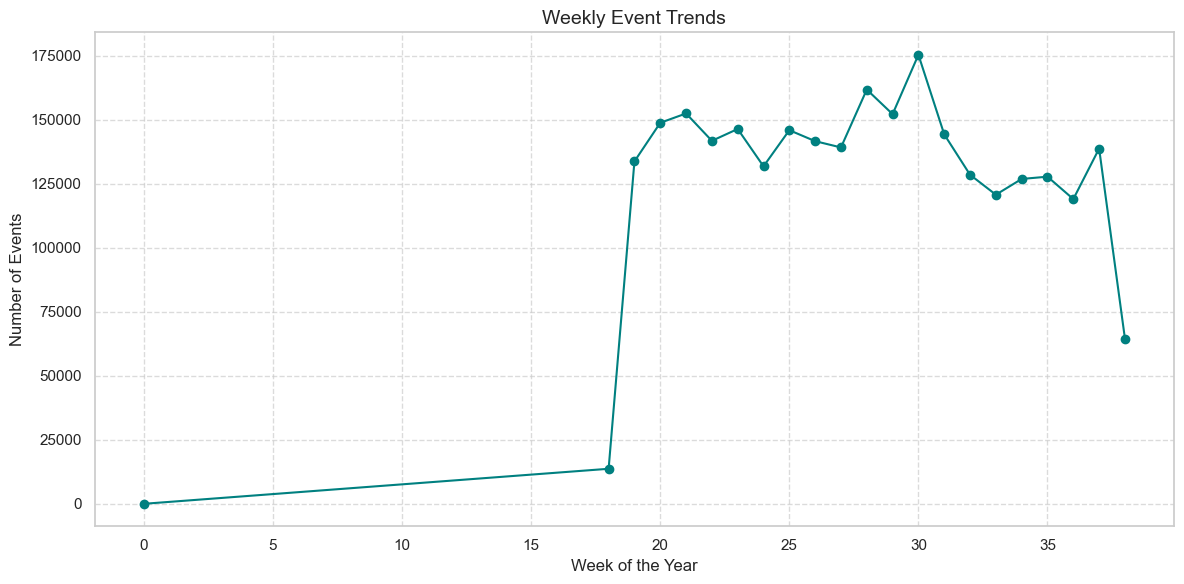

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set chunk size for processing large CSV
CHUNK_SIZE = 10000

# Ensure the visualizations directory exists
visualization_dir = "../visualizations/"
os.makedirs(visualization_dir, exist_ok=True)

# Initialize a Series to count events by week
weekly_events = pd.Series(0)

# Process events.csv in chunks to calculate weekly trends
for chunk in pd.read_csv("../data/events.csv", chunksize=CHUNK_SIZE):
    # Convert timestamp to datetime
    chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], unit='ms')
    # Extract week of the year
    chunk['week'] = chunk['timestamp'].dt.isocalendar().week
    # Count events per week in this chunk
    chunk_weekly = chunk.groupby('week').size()
    # Add to total counts
    weekly_events = weekly_events.add(chunk_weekly, fill_value=0)

# Sort by week
weekly_events = weekly_events.sort_index()

# Plot weekly event trends
plt.figure(figsize=(12, 6))
weekly_events.plot(kind='line', marker='o', color='teal')
plt.title("Weekly Event Trends", fontsize=14)
plt.xlabel("Week of the Year", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure to the visualizations folder
plt.savefig(os.path.join(visualization_dir, "weekly_events.png"))

# Show the plot (optional)
plt.show()

## Seasonal Pattern Insights

- Event volumes show fluctuations, with noticeable peaks that may correspond to sales events or promotions.
- These temporal patterns can inform time-aware recommendations.

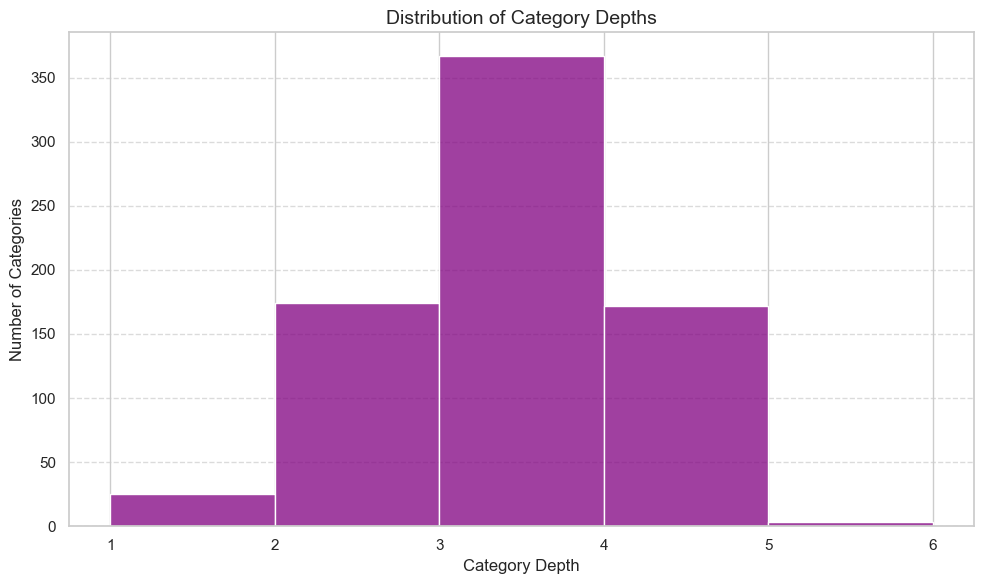

Category Depth Summary:
count    741.000000
mean       2.937922
std        0.784258
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: depth, dtype: float64


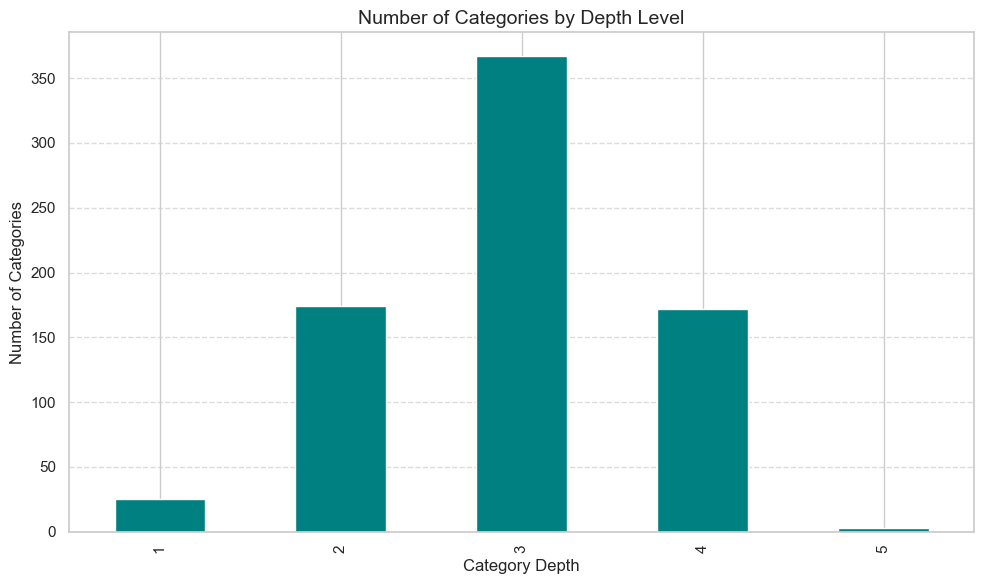

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate category depth
def calculate_category_depth(category_tree):
    """
    Calculate the depth of each category in a hierarchical category tree.
    
    Args:
        category_tree (pd.DataFrame): DataFrame containing category information
    
    Returns:
        dict: Dictionary mapping category IDs to their depth in the tree
    """
    # Initialize depth dictionary for root categories (categories without a parent)
    depth = {row['categoryid']: 1 for _, row in category_tree.iterrows() if pd.isna(row['parentid'])}
    
    # Traverse the tree to calculate depths
    for _, row in category_tree.iterrows():
        if pd.notna(row['parentid']):
            parent_depth = depth.get(row['parentid'], 0)
            if parent_depth > 0:
                depth[row['categoryid']] = parent_depth + 1
    
    return depth

# Ensure the visualizations directory exists
visualization_dir = "../visualizations/"
os.makedirs(visualization_dir, exist_ok=True)

# Calculate category depths
category_depths = calculate_category_depth(category_tree)
depth_df = pd.DataFrame(list(category_depths.items()), columns=['categoryid', 'depth'])

# Plot category depth distribution
plt.figure(figsize=(10, 6))
sns.histplot(depth_df['depth'], bins=range(1, depth_df['depth'].max() + 2), kde=False, color='purple')
plt.title("Distribution of Category Depths", fontsize=14)
plt.xlabel("Category Depth", fontsize=12)
plt.ylabel("Number of Categories", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(visualization_dir, "category_depth.png"))
plt.show()

# Print summary statistics
print("Category Depth Summary:")
print(depth_df['depth'].describe())

# Optional: Create a bar plot of depth distribution
plt.figure(figsize=(10, 6))
depth_counts = depth_df['depth'].value_counts().sort_index()
depth_counts.plot(kind='bar', color='teal')
plt.title("Number of Categories by Depth Level", fontsize=14)
plt.xlabel("Category Depth", fontsize=12)
plt.ylabel("Number of Categories", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the bar plot
plt.savefig(os.path.join(visualization_dir, "category_depth_bar.png"))
plt.show()

## Category Hierarchy Insights

- Most categories are at depth 1 or 2, indicating a relatively shallow hierarchy.
- This structure suggests broad categories can be used for high-level recommendations, while deeper categories can provide more specific suggestions.



<Figure size 1400x700 with 0 Axes>

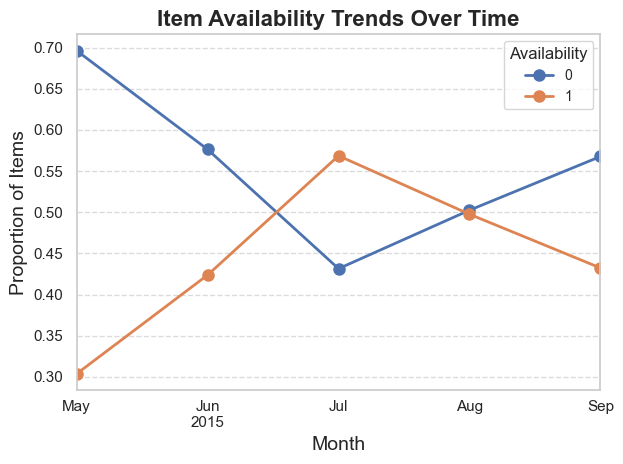

<Figure size 1400x700 with 0 Axes>

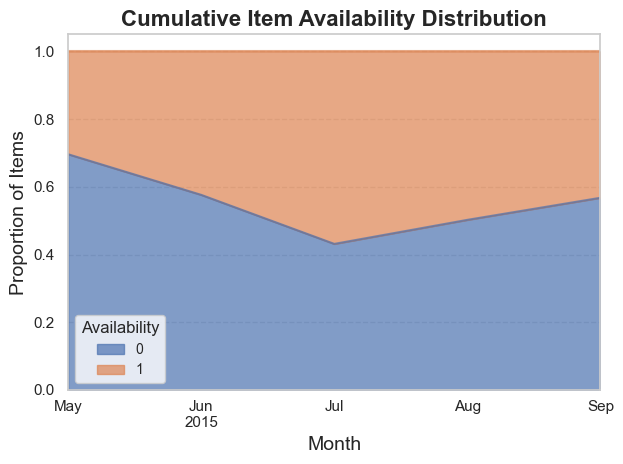

Availability Distribution Summary:
value         0         1
count  5.000000  5.000000
mean   0.554820  0.445180
std    0.098221  0.098221
min    0.431446  0.303761
25%    0.502445  0.423719
50%    0.567687  0.432313
75%    0.576281  0.497555
max    0.696239  0.568554


In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set chunk size for processing large CSV
CHUNK_SIZE = 10000

# Ensure the visualizations directory exists
visualization_dir = "../visualizations/"
os.makedirs(visualization_dir, exist_ok=True)

# Initialize a DataFrame to store availability counts by month
availability_counts = {}

# Process item_properties in chunks
file_paths = ["../data/item_properties_part1.csv", "../data/item_properties_part2.csv"]

for file_path in file_paths:
    for chunk in pd.read_csv(file_path, chunksize=CHUNK_SIZE):
        # Filter for availability property
        chunk = chunk[chunk['property'] == 'available']
        
        # Convert timestamp to datetime
        chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], unit='ms')
        
        # Extract month
        chunk['month'] = chunk['timestamp'].dt.to_period('M')
        
        # Count availability values by month
        monthly_counts = chunk.groupby('month')['value'].value_counts().unstack().fillna(0)
        
        # Accumulate counts
        for month in monthly_counts.index:
            if month in availability_counts:
                availability_counts[month] = availability_counts[month].add(monthly_counts.loc[month], fill_value=0)
            else:
                availability_counts[month] = monthly_counts.loc[month]

# Combine into a DataFrame
availability_by_month = pd.DataFrame(availability_counts).T
availability_by_month = availability_by_month.sort_index()

# Calculate proportions
availability_by_month = availability_by_month.div(availability_by_month.sum(axis=1), axis=0)

# Plot availability trends over time
plt.figure(figsize=(14, 7))
availability_by_month.plot(kind='line', marker='o', linewidth=2, markersize=8)
plt.title("Item Availability Trends Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Proportion of Items", fontsize=14)
plt.legend(title="Availability", title_fontsize=12, fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(visualization_dir, "availability_distribution.png"), dpi=300)
plt.show()

# Create a stacked area plot for a different visualization
plt.figure(figsize=(14, 7))
availability_by_month.plot(kind='area', stacked=True, alpha=0.7)
plt.title("Cumulative Item Availability Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Proportion of Items", fontsize=14)
plt.legend(title="Availability", title_fontsize=12, fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the stacked area plot
plt.savefig(os.path.join(visualization_dir, "availability_distribution_stacked.png"), dpi=300)
plt.show()

# Print summary statistics
print("Availability Distribution Summary:")
print(availability_by_month.describe())

## Item Properties Insights

- Item availability fluctuates over time, with periods where more items are unavailable.
- The stacked area plot highlights the cumulative distribution of availability, showing how the proportion of available vs. unavailable items changes monthly.
- This temporal variability can be used as a feature in the recommendation system to prioritize available items.



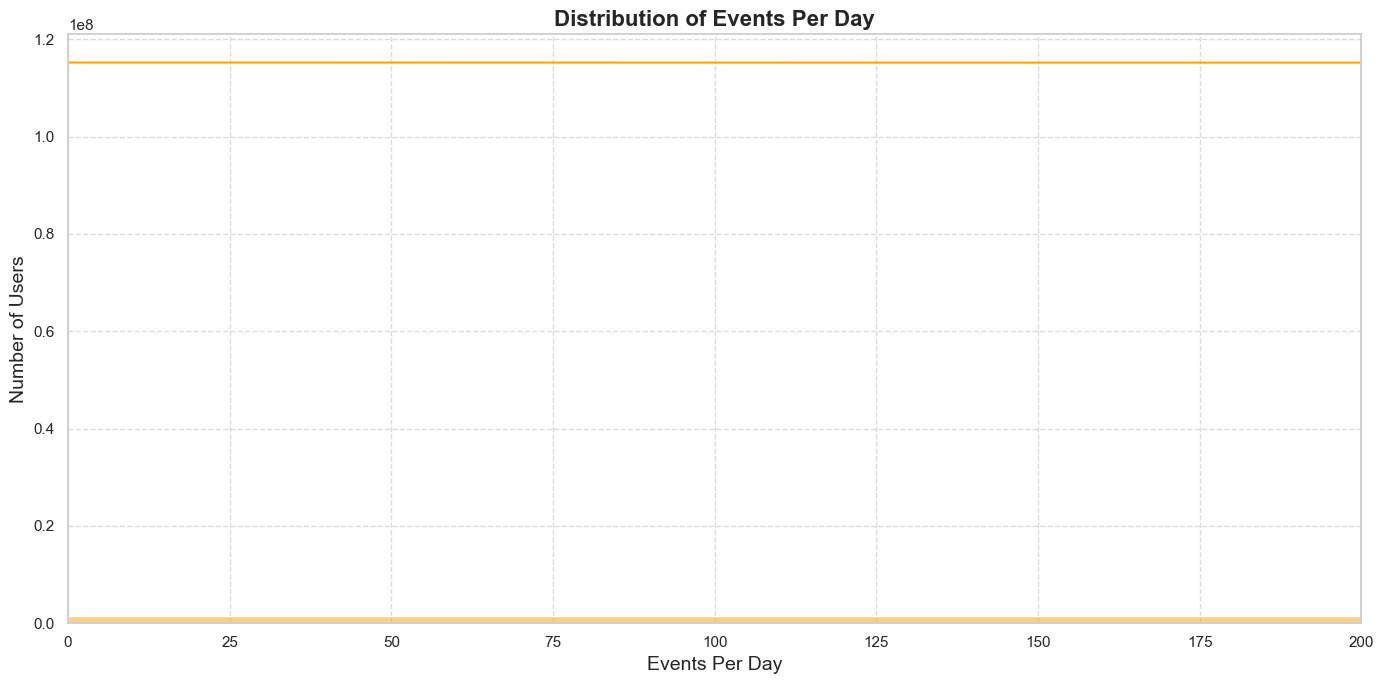

Potential Anomalies (Events Per Day > 100):
potential_anomaly
False    1178159
True      229421
Name: count, dtype: int64


In [17]:
# Initialize user behavior aggregation
user_behavior = {}

# Process events.csv in chunks for user profiling
for chunk in pd.read_csv("../data/events.csv", chunksize=CHUNK_SIZE):
    # Convert timestamp to datetime
    chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], unit='ms')
    # Group by visitorid
    chunk_agg = chunk.groupby('visitorid').agg({
        'event': 'count',  # Total events per user
        'timestamp': ['min', 'max'],  # First and last interaction
        'itemid': 'nunique'  # Unique items interacted with
    }).reset_index()
    # Flatten column names
    chunk_agg.columns = [
        'visitorid',
        'total_events',
        'first_interaction',
        'last_interaction',
        'unique_items'
    ]
    # Accumulate results
    for _, row in chunk_agg.iterrows():
        visitorid = row['visitorid']
        if visitorid in user_behavior:
            user_behavior[visitorid]['total_events'] += row['total_events']
            user_behavior[visitorid]['unique_items'] += row['unique_items']
            user_behavior[visitorid]['first_interaction'] = min(user_behavior[visitorid]['first_interaction'], row['first_interaction'])
            user_behavior[visitorid]['last_interaction'] = max(user_behavior[visitorid]['last_interaction'], row['last_interaction'])
        else:
            user_behavior[visitorid] = {
                'total_events': row['total_events'],
                'first_interaction': row['first_interaction'],
                'last_interaction': row['last_interaction'],
                'unique_items': row['unique_items']
            }

# Convert to DataFrame
user_behavior_df = pd.DataFrame.from_dict(user_behavior, orient='index').reset_index()
user_behavior_df.columns = [
    'visitorid',
    'total_events',
    'first_interaction',
    'last_interaction',
    'unique_items'
]

# Calculate active duration (in days)
user_behavior_df['active_duration'] = (user_behavior_df['last_interaction'] - user_behavior_df['first_interaction']).dt.total_seconds() / (60 * 60 * 24)

# Calculate events per day
user_behavior_df['events_per_day'] = user_behavior_df['total_events'] / user_behavior_df['active_duration'].replace(0, 1)  # Avoid division by zero

# Flag potential anomalies (e.g., users with high events per day)
user_behavior_df['potential_anomaly'] = user_behavior_df['events_per_day'] > 100  # Arbitrary threshold

# Create the preprocessed_data directory if it doesn't exist
preprocessed_data_dir = "../data/preprocessed_data/"
os.makedirs(preprocessed_data_dir, exist_ok=True)

# Save user behavior profiles
user_behavior_df.to_csv(os.path.join(preprocessed_data_dir, "user_behavior.csv"), index=False)

# Plot events per day distribution
plt.figure(figsize=(14, 7))
sns.histplot(user_behavior_df['events_per_day'], bins=50, kde=True, color='orange')
plt.title("Distribution of Events Per Day", fontsize=16, fontweight='bold')
plt.xlabel("Events Per Day", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.xlim(0, 200)  # Limit x-axis for better visualization
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, "active_duration.png"), dpi=300)
plt.show()

# Print anomaly summary
print("Potential Anomalies (Events Per Day > 100):")
print(user_behavior_df['potential_anomaly'].value_counts())

Most users have low interaction frequency, but a small subset exhibits unusually high events per day (>100), suggesting potential bots or power users.

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
base_path = r'c:\Users\hbempong\OneDrive - Imperial General Assurance\Desktop\recommendation system'
data_path = os.path.join(base_path, 'data')
output_path = os.path.join(base_path, 'preprocessed_data')
visualization_dir = os.path.join(base_path, 'visualizations')

# Ensure output directories exist
os.makedirs(output_path, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)  # Ensure visualizations directory exists

# Define chunk size for large datasets
CHUNK_SIZE = 100000  # Process 100,000 rows at a time

# Initialize user behavior aggregation
user_behavior = {}

# Process events.csv in chunks for user profiling
for chunk in pd.read_csv(os.path.join(data_path, 'events.csv'), chunksize=CHUNK_SIZE):
    # Convert timestamp to datetime
    chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], unit='ms')
    # Group by visitorid
    chunk_agg = chunk.groupby('visitorid').agg({
        'event': 'count',  # Total events per user
        'timestamp': ['min', 'max'],  # First and last interaction
        'itemid': 'nunique'  # Unique items interacted with
    }).reset_index()
    # Flatten column names
    chunk_agg.columns = [
        'visitorid',
        'total_events',
        'first_interaction',
        'last_interaction',
        'unique_items'
    ]
    # Accumulate results
    for _, row in chunk_agg.iterrows():
        visitorid = row['visitorid']
        if visitorid in user_behavior:
            user_behavior[visitorid]['total_events'] += row['total_events']
            user_behavior[visitorid]['unique_items'] += row['unique_items']
            user_behavior[visitorid]['first_interaction'] = min(user_behavior[visitorid]['first_interaction'], row['first_interaction'])
            user_behavior[visitorid]['last_interaction'] = max(user_behavior[visitorid]['last_interaction'], row['last_interaction'])
        else:
            user_behavior[visitorid] = {
                'total_events': row['total_events'],
                'first_interaction': row['first_interaction'],
                'last_interaction': row['last_interaction'],
                'unique_items': row['unique_items']
            }

# Convert to DataFrame
user_behavior_df = pd.DataFrame.from_dict(user_behavior, orient='index').reset_index()
user_behavior_df.columns = [
    'visitorid',
    'total_events',
    'first_interaction',
    'last_interaction',
    'unique_items'
]

# Calculate active duration (in days)
user_behavior_df['active_duration'] = (user_behavior_df['last_interaction'] - user_behavior_df['first_interaction']).dt.total_seconds() / (60 * 60 * 24)

# Calculate events per day
user_behavior_df['events_per_day'] = user_behavior_df['total_events'] / user_behavior_df['active_duration'].replace(0, 1)  # Avoid division by zero

# Flag potential anomalies (e.g., users with high events per day)
user_behavior_df['potential_anomaly'] = user_behavior_df['events_per_day'] > 100  # Arbitrary threshold

# Save user behavior profiles
user_behavior_df.to_csv(os.path.join(output_path, "user_behavior.csv"), index=False)

# Plot events per day distribution
plt.figure(figsize=(14, 7))
sns.histplot(user_behavior_df['events_per_day'], bins=50, kde=True, color='orange')
plt.title("Distribution of Events Per Day", fontsize=16, fontweight='bold')
plt.xlabel("Events Per Day", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.xlim(0, 200)  # Limit x-axis for better visualization
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot to the visualizations directory
plt.savefig(os.path.join(visualization_dir, "active_duration.png"), dpi=300)
plt.close()  # Close the plot to free memory

# Print anomaly summary
print("Potential Anomalies (Events Per Day > 100):")
print(user_behavior_df['potential_anomaly'].value_counts())

Potential Anomalies (Events Per Day > 100):
potential_anomaly
False    1178159
True      229421
Name: count, dtype: int64


In [ ]:
# Summary of EDA findings
print("EDA Summary:")
print(f"- Total Events: {event_counts.sum()}")
print(f"- Unique Users: {len(user_behavior_df)}")
print(f"- Unique Items: {len(item_interactions)}")
print(f"- Total Categories: {category_tree['categoryid'].nunique()}")
print(f"- Potential Anomalies: {user_behavior_df['potential_anomaly'].sum()} users")